In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance
from sklearn import linear_model
import scipy
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)

# Data

In [13]:
data = pd.read_excel("../data/midterm_1.xlsx", index_col=0)
data.head()

,CL1,GC1,KC1,ES1,BP1
date,,,,,
2009-01-31,-0.1135,0.0486,0.0611,-0.0861,-0.0078
2009-02-28,0.0447,0.0152,-0.0795,-0.1073,-0.0083
2009-03-31,0.0879,-0.0211,0.0344,0.0872,0.0017
2009-04-30,-0.0138,-0.0365,-0.0065,0.0947,0.0329
2009-05-31,0.2874,0.0983,0.1855,0.0552,0.0889


# 1. Short Answer (30pts)
## 1.1
No. When comes to optimizing portfolio by the mean-variance optimization, the covariance of assets matters, not the individual Sharpe ratios. Crypto has a relatively low covariance to other assets, so it may help make the optimazation better by diversifing risk.

## 1.2
Yes. 
- The regular mean-variance optimazation is fragile due to the covariance and similarities of different assets. Due to the multicollinearity, the inverting covariance matrix is close to zero. 
- Also, the historical mean returns cannot be trusted. 

## 1.3 
For actual data, we find that by using the assumption of **normal distribuion**, we get better estimation of VaR. 

We can do hit test for estimating VaR. Hit ratio is **not** the smaller the better. If the hit ratio is **close to the estimated var**, then this estimation has a better performance. It is 

## 1.4
Harvard mainly used 2 ways to help getting more realistic weights: 
- to add constraints
- to set institutional forcast mean returns other than trust historical returns. 

However, the results are still very dependent on the constraints. The final regression parameters are all close to boundary. 

## 1.5 
- Ridge and LASSO add some punishment to parameters. For Ridge regression, it forces the covariance matrix to a diagnoize-liked matrix, and for LASSO regression, it keeps some of the regreesors and drop others. So they have much better and stable estimation of the covariance matrix. 
- Overall, they solve the multicollinearity. 

## 1.6 
- **HFRIFWI** - Hedge fund Index Series. Index of surveyed hedge funds (2000 Holdings) designed to track the performance of the hedge market as a whole. Monthly returns based on surveys. This can't be launched as an ETF as they need a third party index as benchmark. 

- **MLEIFCTR** - Index Series created by Merrill Lynch, to replicate the performance of HFRI. Its a linear factor decomposition of the HFRI returns into 6 assets. This is not an asset and not an ETF. 

- **HDG** - Actual tradaeble asset trying to track the MLFM-ES, by actually trading on these assets. HDG do not strictly adhere to MLFM-ES replication and would deviate from positions if they can get additional returns or reduce transaction cost. <br><br>

- **Differences:** HFRIFWI and MLEIFCTR are like SPX and SPY, and is MLEIFCTR liquid, large, investiable. HDG is the actual fund, it has some frictions. 

# 2. Allocation (15 pts)
## 2.1 Report the weights of the Global Minimum Variance (GMV) portfolio, ωv, and the weights of the Tangency portfolio, ωt.

In [15]:
def cal_tangency_w(df, annual_factor):
    '''give assets return and annualize factor, return tangency weight'''
    N = df.shape[1]

    Sigma = df.cov() * annual_factor  # covariance matrix, annualized
    mean = df.mean() * annual_factor
    Sigma_inv = np.linalg.inv(Sigma)
    omega_t = (1/(np.ones(N) @ Sigma_inv @ mean)) * Sigma_inv @ mean
    return pd.Series(omega_t, index=df.columns)


def cal_GMV_w(df, annual_factor):
    '''give assets return and annulize factor return global minimum variance weight'''
    N = df.shape[1]

    Sigma = df.cov() * annual_factor  # covariance matrix, annualized
    Sigma_inv = np.linalg.inv(Sigma)
    omega_v = (1/(np.ones(N) @ Sigma_inv @ np.ones(N))) * \
        Sigma_inv @ np.ones(N)
    return pd.Series(omega_v, index=df.columns)

In [18]:
pd.DataFrame(cal_GMV_w(data, annual_factor=12),
             columns=['GMV weight'])


,GMV weight
CL1,-0.0307
GC1,0.1791
KC1,-0.0106
ES1,0.0922
BP1,0.7700


In [17]:
pd.DataFrame(cal_tangency_w(data, annual_factor=12), columns=['tangency weight'])

,tangency weight
CL1,-0.1281
GC1,1.1911
KC1,0.0978
ES1,4.2200
BP1,-4.3808


## 2.2 What are the weights of the optimal portfolio, ω∗, with a targeted total mean return of 0.20 annualized

In [19]:
def cal_delta(mu_p, df, annual_factor=12):
    '''give target mu_p, assets return and annualize factor, return delta and weight'''
    mu_p_ann = mu_p * annual_factor
    mu = df.mean() * annual_factor
    tangency_w = cal_tangency_w(df, annual_factor)
    GMV_w = cal_GMV_w(df, annual_factor)
    delta = (mu_p_ann - mu.T @ GMV_w)/(mu.T @ tangency_w - mu.T @ GMV_w)
    weight_star = delta * tangency_w + (1-delta) * GMV_w
    return delta, weight_star


In [23]:
delta, weight_star = cal_delta(mu_p=0.2, df=data, annual_factor=12)
pd.DataFrame(weight_star, columns=["weight star"])

,weight star
CL1,-0.3984
GC1,3.9982
KC1,0.3987
ES1,15.6703
BP1,-18.6687


## 2.3 Suppose we re-did this problem assuming the existence of a risk-free rate. Would the solution with mean return of 0.20 be guaranteed to have less than or equal volatility as the solution above, where we did not have a risk-free rate? Why?

**Answers:** No. As we can see from the plot, the tangency portfolio has the highest sharpe ratio in every Effective Frontier portfolios. So if we have a risk-free rate lower than zero, which can be happened, we may get higher volatility in order to get the same mean return as other effective frontier portfolio. However, if risk free rate is better than or equal to zero, we may be garanteed to have a less volatility. 

# 3. Hedging & Replication
## 3.1 Report the last five values of the timeseries of alpha and beta estimates.

In [80]:
y = data["BP1"]
X = data["ES1"]
X = sm.add_constant(X)
model = RollingOLS(y, X, window=36)
rolling_paras = model.fit().params.copy()
replication_result = (rolling_paras * X).sum(axis=1)
rolling_paras.columns = ["alpha", "beta"]

In [82]:
rolling_paras.tail()

,alpha,beta
date,,
2022-02-28,-0.0030,0.2479
2022-03-31,-0.0032,0.2412
2022-04-30,-0.0037,0.2579
2022-05-31,-0.0031,0.2478
2022-06-30,-0.0033,0.2584


## 3.2 Report the last five values of the timeseries

In [83]:
rep_result = replication_result.iloc[35:].copy()
rep_result = pd.DataFrame(rep_result, columns=["rep_result"])
rep_result.tail()

,rep_result
date,
2022-02-28,-0.0105
2022-03-31,0.0063
2022-04-30,-0.0266
2022-05-31,-0.0029
2022-06-30,-0.0248


## 3.3 Report the mean, volatility and mean-to-vol ratio of this replicated position, r∗. Annualize the statistics.

In [84]:
def summary_stat(df, annual_factor):
    '''summary assets' mean return, voaltility(stdev) and sharpe ratio'''
    result = pd.DataFrame()
    result["mean"] = df.mean() * annual_factor
    result["volatility"] = df.std() * np.sqrt(annual_factor)
    result["mean-to-vol Ratio"] = result["mean"]/result["volatility"]
    return result

In [85]:
summary_stat(df=pd.DataFrame(rep_result,
             columns=["rep_result"]), annual_factor=12)


,mean,volatility,mean-to-vol Ratio
rep_result,-0.0155,0.0394,-0.3937


## 3.4 How correlated is this replicated position, r∗, to ES1

In [86]:
res = pd.DataFrame(columns=["ES1", "rep_result"])
res["ES1"] = y
res["rep_result"] = replication_result
res = res.iloc[35:].copy()
res.corr()

,ES1,rep_result
ES1,1.0000,0.4939
rep_result,0.4939,1.0000


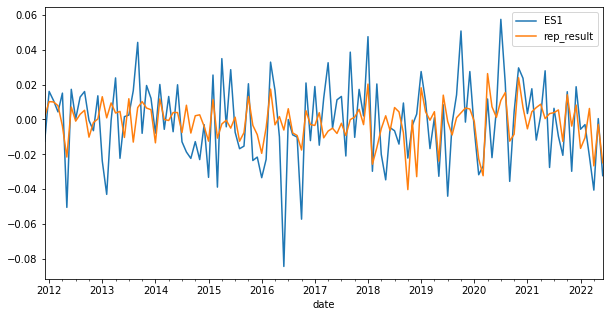

In [87]:
res.plot(figsize=(10, 5))

In [138]:
# those two assets correlation, just reports for comparision, not an answer. 
data[["ES1", "BP1"]].corr()

,ES1,BP1
ES1,1.0000,0.4648
BP1,0.4648,1.0000


In [139]:
res.corr()

,ES1,rep_result
ES1,1.0000,0.4939
rep_result,0.4939,1.0000


**Answers:** The correlation between these two is 0.49, a little bit higher than the correlation between ES1 & BP1. So ES1 cannot be replicated simply by BP1, there are some different risks of these two assets. 

# 4. Modeling Risk
## 4.1 Compare the performance statistics between ES1, GC1, and the 50/50 portfolio. Annu-
alize mean and volatility.

In [140]:
portfolio_data = data[["ES1", "GC1"]]
portfolio_data["50/50 portfolio"] = 0.5*portfolio_data["ES1"] + 0.5*portfolio_data["GC1"]
portfolio_data.head()

,ES1,GC1,50/50 portfolio
date,,,
2009-01-31,-0.0861,0.0486,-0.0187
2009-02-28,-0.1073,0.0152,-0.0461
2009-03-31,0.0872,-0.0211,0.0330
2009-04-30,0.0947,-0.0365,0.0291
2009-05-31,0.0552,0.0983,0.0767


In [141]:
def Metrics(df, annual_factor, relative=False, mdd=True):
    result = pd.DataFrame()
    result["mean"] = df.mean() * annual_factor
    result["volatility"] = df.std() * np.sqrt(annual_factor)
    result["mean-to-vol Ratio"] = result["mean"]/result["volatility"]

    cum_returns = (1 + df).cumprod()
    rolling_max = cum_returns.cummax()  # cummax function
    drawdown = (cum_returns - rolling_max) / rolling_max

    max_drawdown = drawdown.min()
    result['Max Drawdown'] = max_drawdown
    return result


Metrics(portfolio_data, annual_factor=12)

,mean,volatility,mean-to-vol Ratio,Max Drawdown
ES1,0.1291,0.1511,0.8547,-0.2032
GC1,0.0540,0.1601,0.3373,-0.4296
50/50 portfolio,0.0916,0.1141,0.8026,-0.1210


## 4.2 How does the 50/50 portfolio compare to the individual components in terms of 
- volatility
- maximum drawdown
- mean-to-vol ratio

**Answers:**

- 50/50 portfolio has a lower volatility, lower maximum drawdown, however, it has a lower mean-to-vol ratio than equity. 
- Yes. It is as expected from the portfolio theory. We do not optimize the mean-to-vol ratio here, if we optimize it, we can have a higher ratio of our portfolio than this two assets. However, by diversification, we do cut down the risk by reducing the volatility and the maximum drawdown. 

## 4.3 Calculate the 1-period, 1% CVaR of the 50/50 portfolio analytically.
### 4.3.1 Full sample estimation

In [121]:
portfolio = portfolio_data["50/50 portfolio"]
z_phi = stats.norm.ppf(0.01)
var = portfolio.std()
cvar = - stats.norm.pdf(z_phi)/0.01*var
print(cvar)

-0.08777058366877924


### 4.3.2 Rolling 24 month volatility estimation

In [153]:
rolling_mu = portfolio.shift().rolling(24).mean()
rolling_vol = np.sqrt((portfolio**2).shift().rolling(24).mean())
# fi = - rolling_mu/rolling_vol
CVaR_ls = []
for var in rolling_vol:
    # cvar = stats.norm.expect(scale=var, ub=var*(-1.65))/0.05 # same answers
    cvar = - stats.norm.pdf(z_phi)/0.01*var
    CVaR_ls.append(cvar)
CVaR = pd.DataFrame(CVaR_ls, index=rolling_mu.index, columns=["CVaR"])

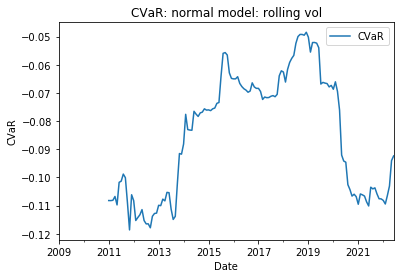

In [154]:
CVaR.plot()

plt.title('CVaR: normal model: rolling vol')
plt.ylabel('CVaR')
plt.xlabel('Date')
plt.show()

In [155]:
CVaR.iloc[-1]

CVaR   -0.0924
Name: 2022-06-30 00:00:00, dtype: float64

## 4.4 What is the probability that over the next 10 years, ES1 underperforms the 50/50 portfolio

$$
Pr(R ^ {50/50}_{t, t+10} > R ^ {ES1}_{t, t+10})
= Pr(\overline{R ^ {50/50}_{t, t+10}} >\overline{R ^ {ES1}_{t, t+10}})
= Pr(\overline{R ^ {50/50}_{t, t+10}} - \overline{R ^ {ES1}_{t, t+10}} > 0)
$$

$$
\overline{R ^ {50/50}_{t, t+10}} - \overline{R ^ {ES1}_{t, t+10}} \sim N(\mu_{50/50} - \mu_{ES1}, \dfrac{Var(R ^ {50/50} - R ^ {ES1})}{10})
$$


In [148]:
portfolio_data["R_diff"] = np.log(
    1+portfolio_data['ES1']) - np.log(1+portfolio_data['50/50 portfolio'])

In [149]:
tilde_mu = portfolio_data['R_diff'].mean()*12
tilde_sigma = portfolio_data['R_diff'].std()*np.sqrt(12)


def p(h, tilde_mu, tilde_sigma):
    x = - np.sqrt(h) * tilde_mu / tilde_sigma
    val = scipy.stats.norm.cdf(x)
    return val

print(
    f"The probability of ES1 underperforming 50/50 portfolio over the next 10 years is {1 - p(10, tilde_mu, tilde_sigma)}.")


The probability of ES1 underperforming 50/50 portfolio over the next 10 years is 0.8316345539308929.
